In [1]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1200])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1200])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [4]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear'):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

In [5]:
#RANDOM_SELECTION()
#RANDOM_SELECTION(kernel='linear')

#data.kernel_matrix = 'poly'
#RANDOM_SELECTION(kernel='precomputed')

#data.kernel_matrix = None
#RANDOM_SELECTION(kernel='poly')

# SVM

In [6]:
@time_func
def SVM_RFE_W_STEP(step, C = 0.5, gamma = 3, kernel = 'linear', w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    kf = KFold(n_splits=6, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(kernel, C, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

rbf 0.3 0.026


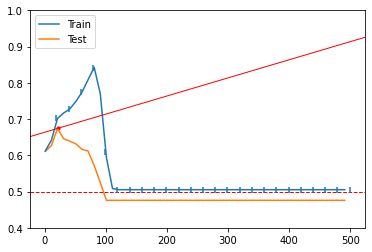

AT (21, 0.6741666666666667, 0.2690666666666667) WITH 25 ITERATIONS IN 477.4129424889882 SECONDS : 43.316240444287985
__main__.SVM_RFE_W_STEP - 00:08:09.447353600
rbf 0.3 0.028


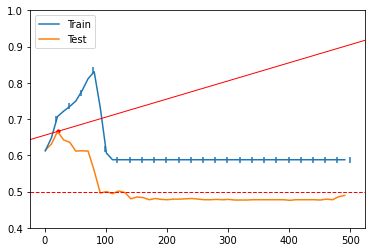

AT (21, 0.6658333333333333, 0.2757333333333334) WITH 25 ITERATIONS IN 465.9503741661708 SECONDS : 29.52780510992946
__main__.SVM_RFE_W_STEP - 00:07:56.763265200
rbf 0.3 0.03


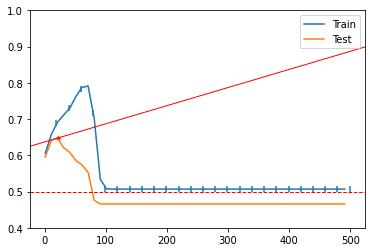

AT (21, 0.6475, 0.29040000000000005) WITH 25 ITERATIONS IN 434.13374614715576 SECONDS : 0.2313471479425857
__main__.SVM_RFE_W_STEP - 00:07:20.642095000
rbf 0.3 0.032


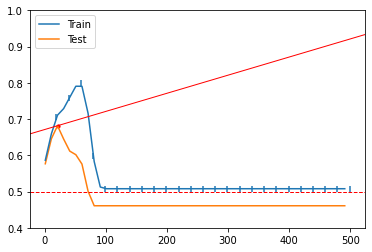

AT (21, 0.6816666666666666, 0.2630666666666667) WITH 25 ITERATIONS IN 430.91707984606427 SECONDS : 62.49438259150981
__main__.SVM_RFE_W_STEP - 00:07:22.032494400
rbf 0.3 0.034


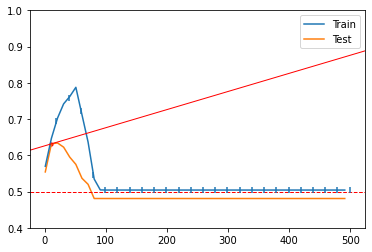

AT (11, 0.6316666666666667, 0.29906666666666665) WITH 25 ITERATIONS IN 433.1677949825923 SECONDS : 0.8768843231728817
__main__.SVM_RFE_W_STEP - 00:07:19.708466800
rbf 0.3 0.036


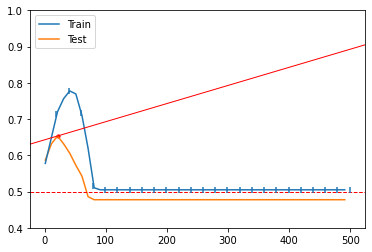

AT (21, 0.6533333333333333, 0.2857333333333334) WITH 25 ITERATIONS IN 431.0663788318634 SECONDS : 57.8615439731744
__main__.SVM_RFE_W_STEP - 00:07:21.564900000
rbf 0.3 0.038


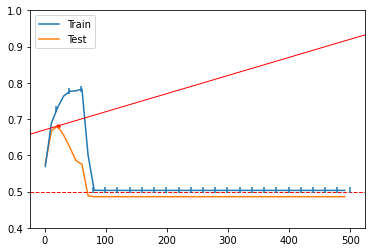

AT (21, 0.6808333333333335, 0.2637333333333332) WITH 25 ITERATIONS IN 432.61542729536694 SECONDS : 0.4079857840269941
__main__.SVM_RFE_W_STEP - 00:07:19.078175400
rbf 0.3 0.04


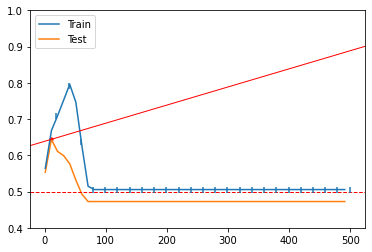

AT (11, 0.6441666666666667, 0.2890666666666667) WITH 25 ITERATIONS IN 430.7079204718272 SECONDS : 46.24975467133964
__main__.SVM_RFE_W_STEP - 00:07:20.969888500
rbf 0.3 0.042


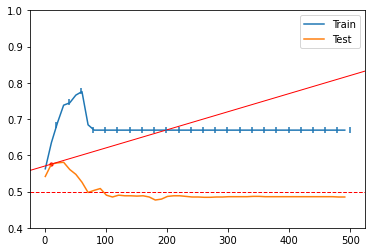

AT (11, 0.5758333333333333, 0.3437333333333334) WITH 25 ITERATIONS IN 431.1551918188731 SECONDS : 62.49883543732281
__main__.SVM_RFE_W_STEP - 00:07:22.139187900
rbf 0.3 0.044


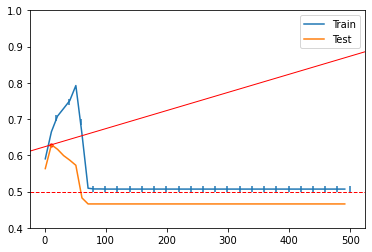

AT (11, 0.6291666666666667, 0.3010666666666667) WITH 25 ITERATIONS IN 432.5761728286743 SECONDS : 0.3300687338679988
__main__.SVM_RFE_W_STEP - 00:07:19.105253900
rbf 0.3 0.046


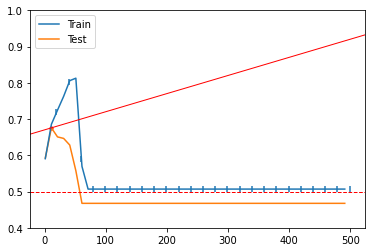

AT (11, 0.6758333333333333, 0.2637333333333334) WITH 25 ITERATIONS IN 432.9993457396825 SECONDS : 0.20686364875845542
__main__.SVM_RFE_W_STEP - 00:07:19.351135200


In [7]:
SVM_RFE_W_STEP(20, 0.3, 0.026, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.028, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.030, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.032, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.034, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.036, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.038, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.042, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.044, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.046, 'rbf')

rbf 0.4 0.026


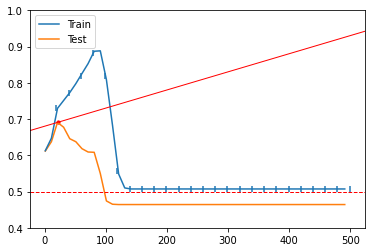

AT (21, 0.6908333333333333, 0.25573333333333337) WITH 25 ITERATIONS IN 431.7370279630025 SECONDS : 0.4301898913379065
__main__.SVM_RFE_W_STEP - 00:07:18.157720500
rbf 0.4 0.028


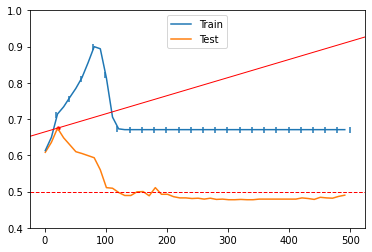

AT (21, 0.6749999999999999, 0.2684000000000001) WITH 25 ITERATIONS IN 431.9619046052297 SECONDS : 0.19319253794237864
__main__.SVM_RFE_W_STEP - 00:07:18.249390100
rbf 0.4 0.03


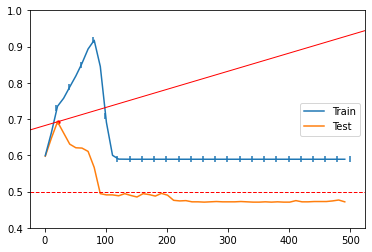

AT (21, 0.6925, 0.2544) WITH 25 ITERATIONS IN 432.4854176044464 SECONDS : 0.5726642484995068
__main__.SVM_RFE_W_STEP - 00:07:18.947272300
rbf 0.4 0.032


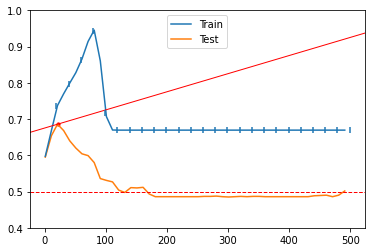

AT (21, 0.6858333333333334, 0.2597333333333333) WITH 25 ITERATIONS IN 431.98329842090607 SECONDS : 1.0212076302863455
__main__.SVM_RFE_W_STEP - 00:07:18.360274300
rbf 0.4 0.034


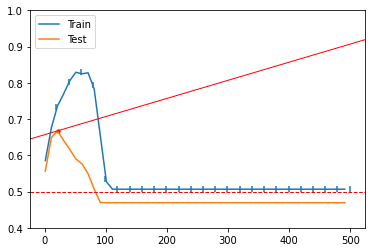

AT (21, 0.6675, 0.27440000000000003) WITH 25 ITERATIONS IN 431.1588352918625 SECONDS : 54.213644607640475
__main__.SVM_RFE_W_STEP - 00:07:21.614903600
rbf 0.4 0.036


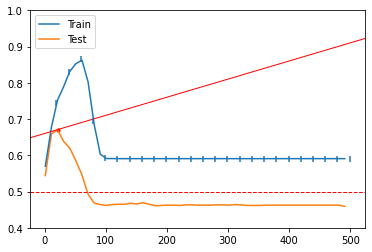

AT (21, 0.6708333333333334, 0.2717333333333333) WITH 25 ITERATIONS IN 431.7662982940674 SECONDS : 0.42351724111525374
__main__.SVM_RFE_W_STEP - 00:07:18.286029100
rbf 0.4 0.038


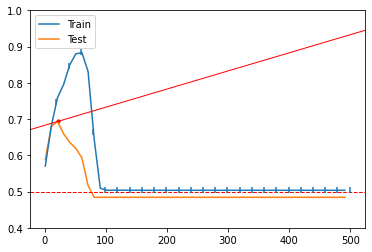

AT (21, 0.6933333333333334, 0.2537333333333333) WITH 25 ITERATIONS IN 431.8318737745285 SECONDS : 0.14848840147782974
__main__.SVM_RFE_W_STEP - 00:07:18.086235000
rbf 0.4 0.04


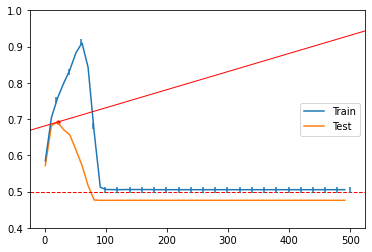

AT (21, 0.6916666666666668, 0.2550666666666666) WITH 25 ITERATIONS IN 430.2207153638204 SECONDS : 57.128714230870635
__main__.SVM_RFE_W_STEP - 00:07:20.748012600
rbf 0.4 0.042


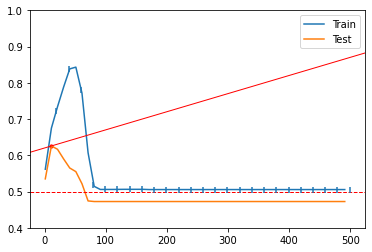

AT (11, 0.6258333333333334, 0.30373333333333336) WITH 25 ITERATIONS IN 430.5921706755956 SECONDS : 47.21281922792906
__main__.SVM_RFE_W_STEP - 00:07:20.759865600
rbf 0.4 0.044


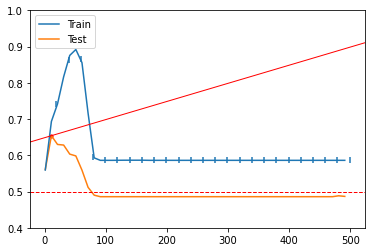

AT (11, 0.6541666666666667, 0.2810666666666667) WITH 25 ITERATIONS IN 430.5639995733897 SECONDS : 49.00122450120966
__main__.SVM_RFE_W_STEP - 00:07:20.834219600
rbf 0.4 0.046


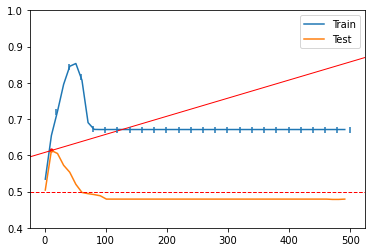

AT (11, 0.6133333333333334, 0.3137333333333333) WITH 25 ITERATIONS IN 432.14266236623126 SECONDS : 0.15556873897589993
__main__.SVM_RFE_W_STEP - 00:07:18.572432300


In [8]:
SVM_RFE_W_STEP(20, 0.4, 0.026, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.028, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.030, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.032, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.034, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.036, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.038, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.042, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.044, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.046, 'rbf')

rbf 0.5 0.026


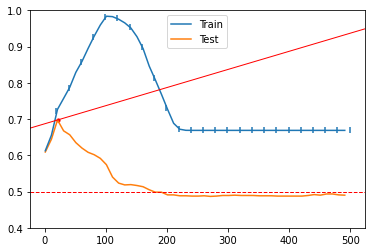

AT (21, 0.6974999999999999, 0.2504000000000001) WITH 25 ITERATIONS IN 425.52108204364777 SECONDS : 0.5450980637974064
__main__.SVM_RFE_W_STEP - 00:07:11.745861600
rbf 0.5 0.028


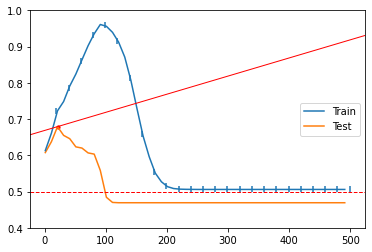

AT (21, 0.6791666666666667, 0.2650666666666667) WITH 25 ITERATIONS IN 424.4729788303375 SECONDS : 53.276270047792956
__main__.SVM_RFE_W_STEP - 00:07:14.821868400
rbf 0.5 0.03


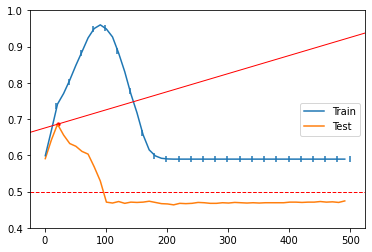

AT (21, 0.6858333333333332, 0.2597333333333335) WITH 25 ITERATIONS IN 425.3608896334966 SECONDS : 0.8693577229943309
__main__.SVM_RFE_W_STEP - 00:07:11.672611900
rbf 0.5 0.032


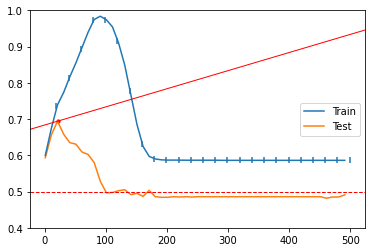

AT (21, 0.6941666666666667, 0.25306666666666666) WITH 25 ITERATIONS IN 424.7558201948802 SECONDS : 50.66424831087022
__main__.SVM_RFE_W_STEP - 00:07:14.936952200
rbf 0.5 0.034


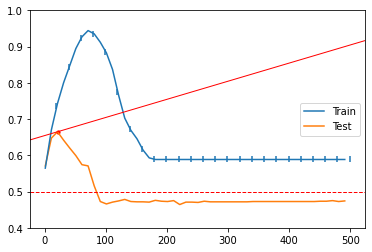

AT (21, 0.6649999999999999, 0.2764000000000001) WITH 25 ITERATIONS IN 425.47854880491894 SECONDS : 0.33168850903235464
__main__.SVM_RFE_W_STEP - 00:07:11.817082500
rbf 0.5 0.036


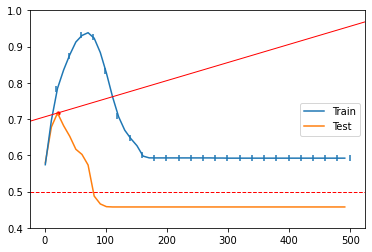

AT (21, 0.7166666666666667, 0.23506666666666667) WITH 25 ITERATIONS IN 426.23524220784503 SECONDS : 0.3018228820908967
__main__.SVM_RFE_W_STEP - 00:07:12.717474100
rbf 0.5 0.038


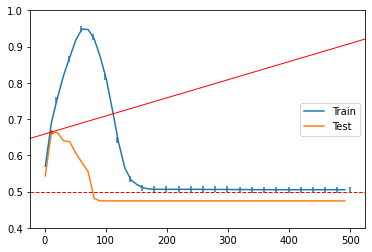

AT (11, 0.6641666666666667, 0.2730666666666667) WITH 25 ITERATIONS IN 426.05010998249054 SECONDS : 2.431516013754082
__main__.SVM_RFE_W_STEP - 00:07:12.718992600
rbf 0.5 0.04


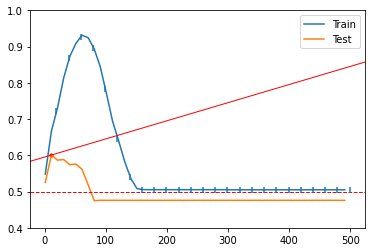

AT (11, 0.6008333333333333, 0.3237333333333334) WITH 25 ITERATIONS IN 424.19211530685425 SECONDS : 46.273102263430054
__main__.SVM_RFE_W_STEP - 00:07:14.371780900
rbf 0.5 0.042


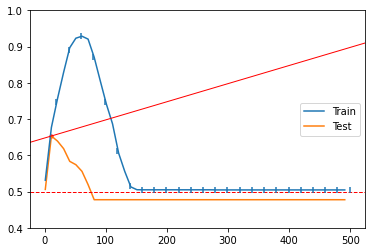

AT (11, 0.6533333333333333, 0.2817333333333334) WITH 25 ITERATIONS IN 423.7876923084259 SECONDS : 62.298696564476664
__main__.SVM_RFE_W_STEP - 00:07:14.578651500
rbf 0.5 0.044


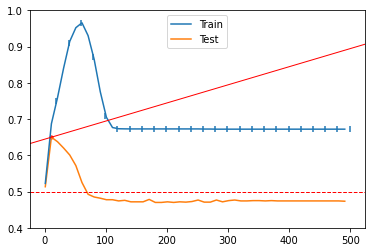

AT (11, 0.65, 0.2844) WITH 25 ITERATIONS IN 423.96025272210437 SECONDS : 52.14457489390858
__main__.SVM_RFE_W_STEP - 00:07:14.391157800
rbf 0.5 0.046


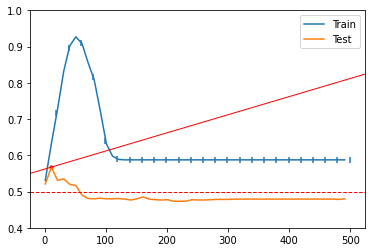

AT (11, 0.5675, 0.35040000000000004) WITH 25 ITERATIONS IN 426.11386597156525 SECONDS : 0.08582345166541454
__main__.SVM_RFE_W_STEP - 00:07:12.299219800


In [9]:
SVM_RFE_W_STEP(20, 0.5, 0.026, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.028, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.030, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.032, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.034, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.036, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.038, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.042, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.044, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.046, 'rbf')

rbf 0.6 0.026


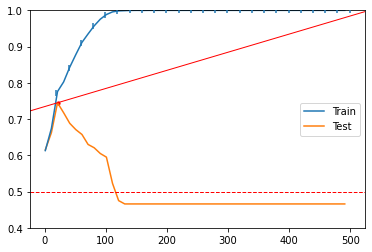

AT (21, 0.745, 0.2124) WITH 25 ITERATIONS IN 424.9259290297826 SECONDS : 0.15848394298053217
__main__.SVM_RFE_W_STEP - 00:07:11.090019200
rbf 0.6 0.028


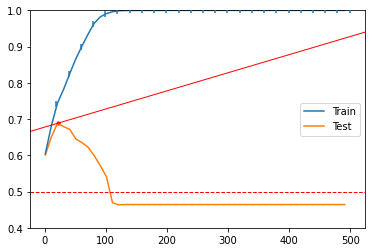

AT (21, 0.6883333333333334, 0.2577333333333333) WITH 25 ITERATIONS IN 425.0538160800934 SECONDS : 0.2936379540753175
__main__.SVM_RFE_W_STEP - 00:07:11.412719100
rbf 0.6 0.03


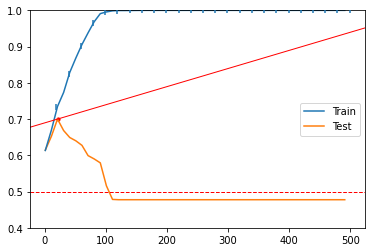

AT (21, 0.7000000000000001, 0.24839999999999995) WITH 25 ITERATIONS IN 424.0267117023468 SECONDS : 70.48335678676102
__main__.SVM_RFE_W_STEP - 00:07:15.210541900
rbf 0.6 0.032


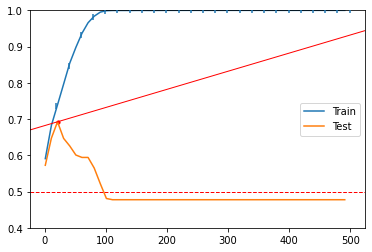

AT (21, 0.6924999999999999, 0.2544000000000001) WITH 25 ITERATIONS IN 426.04094131787616 SECONDS : 1.01259285660472
__main__.SVM_RFE_W_STEP - 00:07:12.629166100
rbf 0.6 0.034


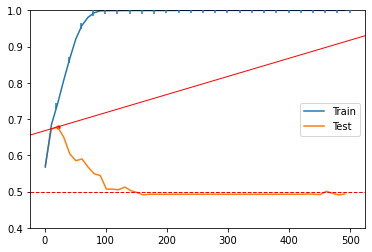

AT (21, 0.6783333333333333, 0.2657333333333334) WITH 25 ITERATIONS IN 425.4008577267329 SECONDS : 0.82827617871994
__main__.SVM_RFE_W_STEP - 00:07:11.700260000
rbf 0.6 0.036


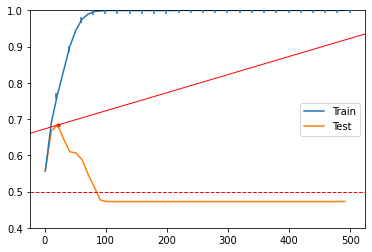

AT (21, 0.6833333333333335, 0.26173333333333326) WITH 25 ITERATIONS IN 425.8491681416829 SECONDS : 0.07020165890334182
__main__.SVM_RFE_W_STEP - 00:07:12.149521000
rbf 0.6 0.038


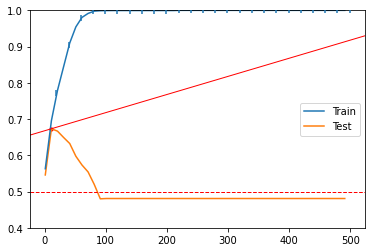

AT (11, 0.6733333333333333, 0.2657333333333334) WITH 25 ITERATIONS IN 425.37658329804736 SECONDS : 0.15788455813839952
__main__.SVM_RFE_W_STEP - 00:07:11.757928800
rbf 0.6 0.04


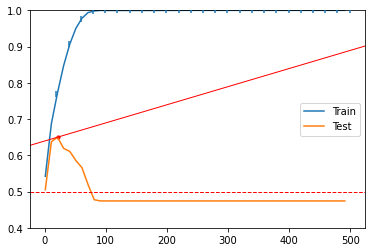

AT (21, 0.65, 0.2884) WITH 25 ITERATIONS IN 423.10724071661633 SECONDS : 51.20688645964692
__main__.SVM_RFE_W_STEP - 00:07:13.497834100
rbf 0.6 0.042


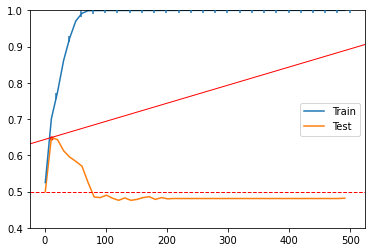

AT (11, 0.6491666666666667, 0.2850666666666667) WITH 25 ITERATIONS IN 422.4981956879298 SECONDS : 56.57355621146192
__main__.SVM_RFE_W_STEP - 00:07:13.014261300
rbf 0.6 0.044


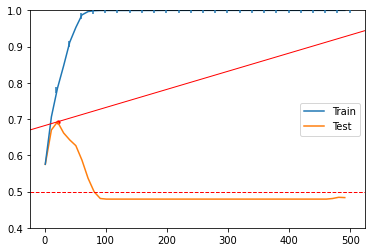

AT (21, 0.6925, 0.2544) WITH 25 ITERATIONS IN 423.8773901462555 SECONDS : 3.2218679049230445
__main__.SVM_RFE_W_STEP - 00:07:10.618959600
rbf 0.6 0.046


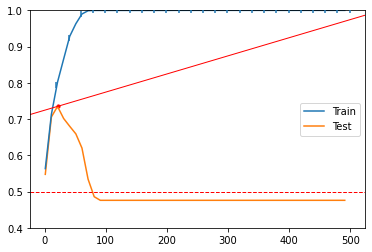

AT (21, 0.735, 0.2204) WITH 25 ITERATIONS IN 423.77427184581757 SECONDS : 1.0053556595137774
__main__.SVM_RFE_W_STEP - 00:07:10.430407500


In [10]:
SVM_RFE_W_STEP(20, 0.6, 0.026, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.028, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.030, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.032, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.034, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.036, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.038, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.042, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.044, 'rbf')
SVM_RFE_W_STEP(20, 0.6, 0.046, 'rbf')